In [15]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import xarray as xr
from pymc_extras.prior import Censored, Prior

from pymc_marketing.mmm import (
    GeometricAdstock,
    MichaelisMentenSaturation,
    NoAdstock,
    NoSaturation,
)
from pymc_marketing.mmm.multidimensional import MMM
from pymc_marketing.paths import data_dir

az.style.use("arviz-darkgrid")
plt.rcParams["figure.figsize"] = [12, 7]
plt.rcParams["figure.dpi"] = 100
plt.rcParams["figure.facecolor"] = "white"

%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = "retina"

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
SEED = 142
rng = np.random.default_rng(SEED)

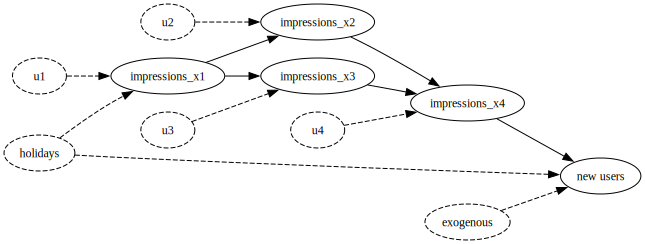

In [20]:
import graphviz

# Create the causal DAG
causal_dag = graphviz.Digraph("causal_dag")
causal_dag.attr(rankdir="LR")
causal_dag.attr("node", fontsize="12")

# Observed nodes
causal_dag.node("x1", "impressions_x1")
causal_dag.node("x2", "impressions_x2")
causal_dag.node("x3", "impressions_x3")
causal_dag.node("x4", "impressions_x4")
causal_dag.node("holidays", "holidays", shape="ellipse", style="dashed")
causal_dag.node("exogenous", "exogenous", shape="ellipse", style="dashed")
causal_dag.node("y", "new users")

# Exogenous vectors (unobserved)
causal_dag.node("u1", shape="ellipse", style="dashed")
causal_dag.node("u2", shape="ellipse", style="dashed")
causal_dag.node("u3", shape="ellipse", style="dashed")
causal_dag.node("u4", shape="ellipse", style="dashed")

# Exogenous parents
causal_dag.edge("u1", "x1", style="dashed")
causal_dag.edge("u2", "x2", style="dashed")
causal_dag.edge("u3", "x3", style="dashed")
causal_dag.edge("u4", "x4", style="dashed")

# Structural edges with coefficient labels
causal_dag.edge("x1", "x2")
causal_dag.edge("x1", "x3")
causal_dag.edge("x2", "x4")
causal_dag.edge("x3", "x4")

# add x4 to y, and holidays to y, and exogenous to y
causal_dag.edge("x4", "y")
causal_dag.edge("holidays", "y", style="dashed")
causal_dag.edge("exogenous", "y", style="dashed")

# holiday to x1
causal_dag.edge("holidays", "x1", style="dashed")

causal_dag

In [3]:
data = pd.read_csv(data_dir / "funnel_data.csv", parse_dates=["date"])

data.head()

,date,target_var,impressions_x1,impressions_x2,impressions_x3,impressions_x4,event_2020_09,event_2020_12,event_2021_09,event_2021_12,event_2022_09,trend
0,2022-01-01,0.4966,0.1577,0.1194,0.2208,0.1134,0.0,0.0,0.0,0.0,0.0,0
1,2022-01-02,0.5341,0.1394,0.1169,0.2263,0.1157,0.0,0.0,0.0,0.0,0.0,1
2,2022-01-03,0.5659,0.1712,0.1177,0.2268,0.1240,0.0,0.0,0.0,0.0,0.0,2
3,2022-01-04,0.5761,0.1175,0.1163,0.2247,0.1221,0.0,0.0,0.0,0.0,0.0,3
4,2022-01-05,0.5679,0.0927,0.1177,0.2209,0.1156,0.0,0.0,0.0,0.0,0.0,4


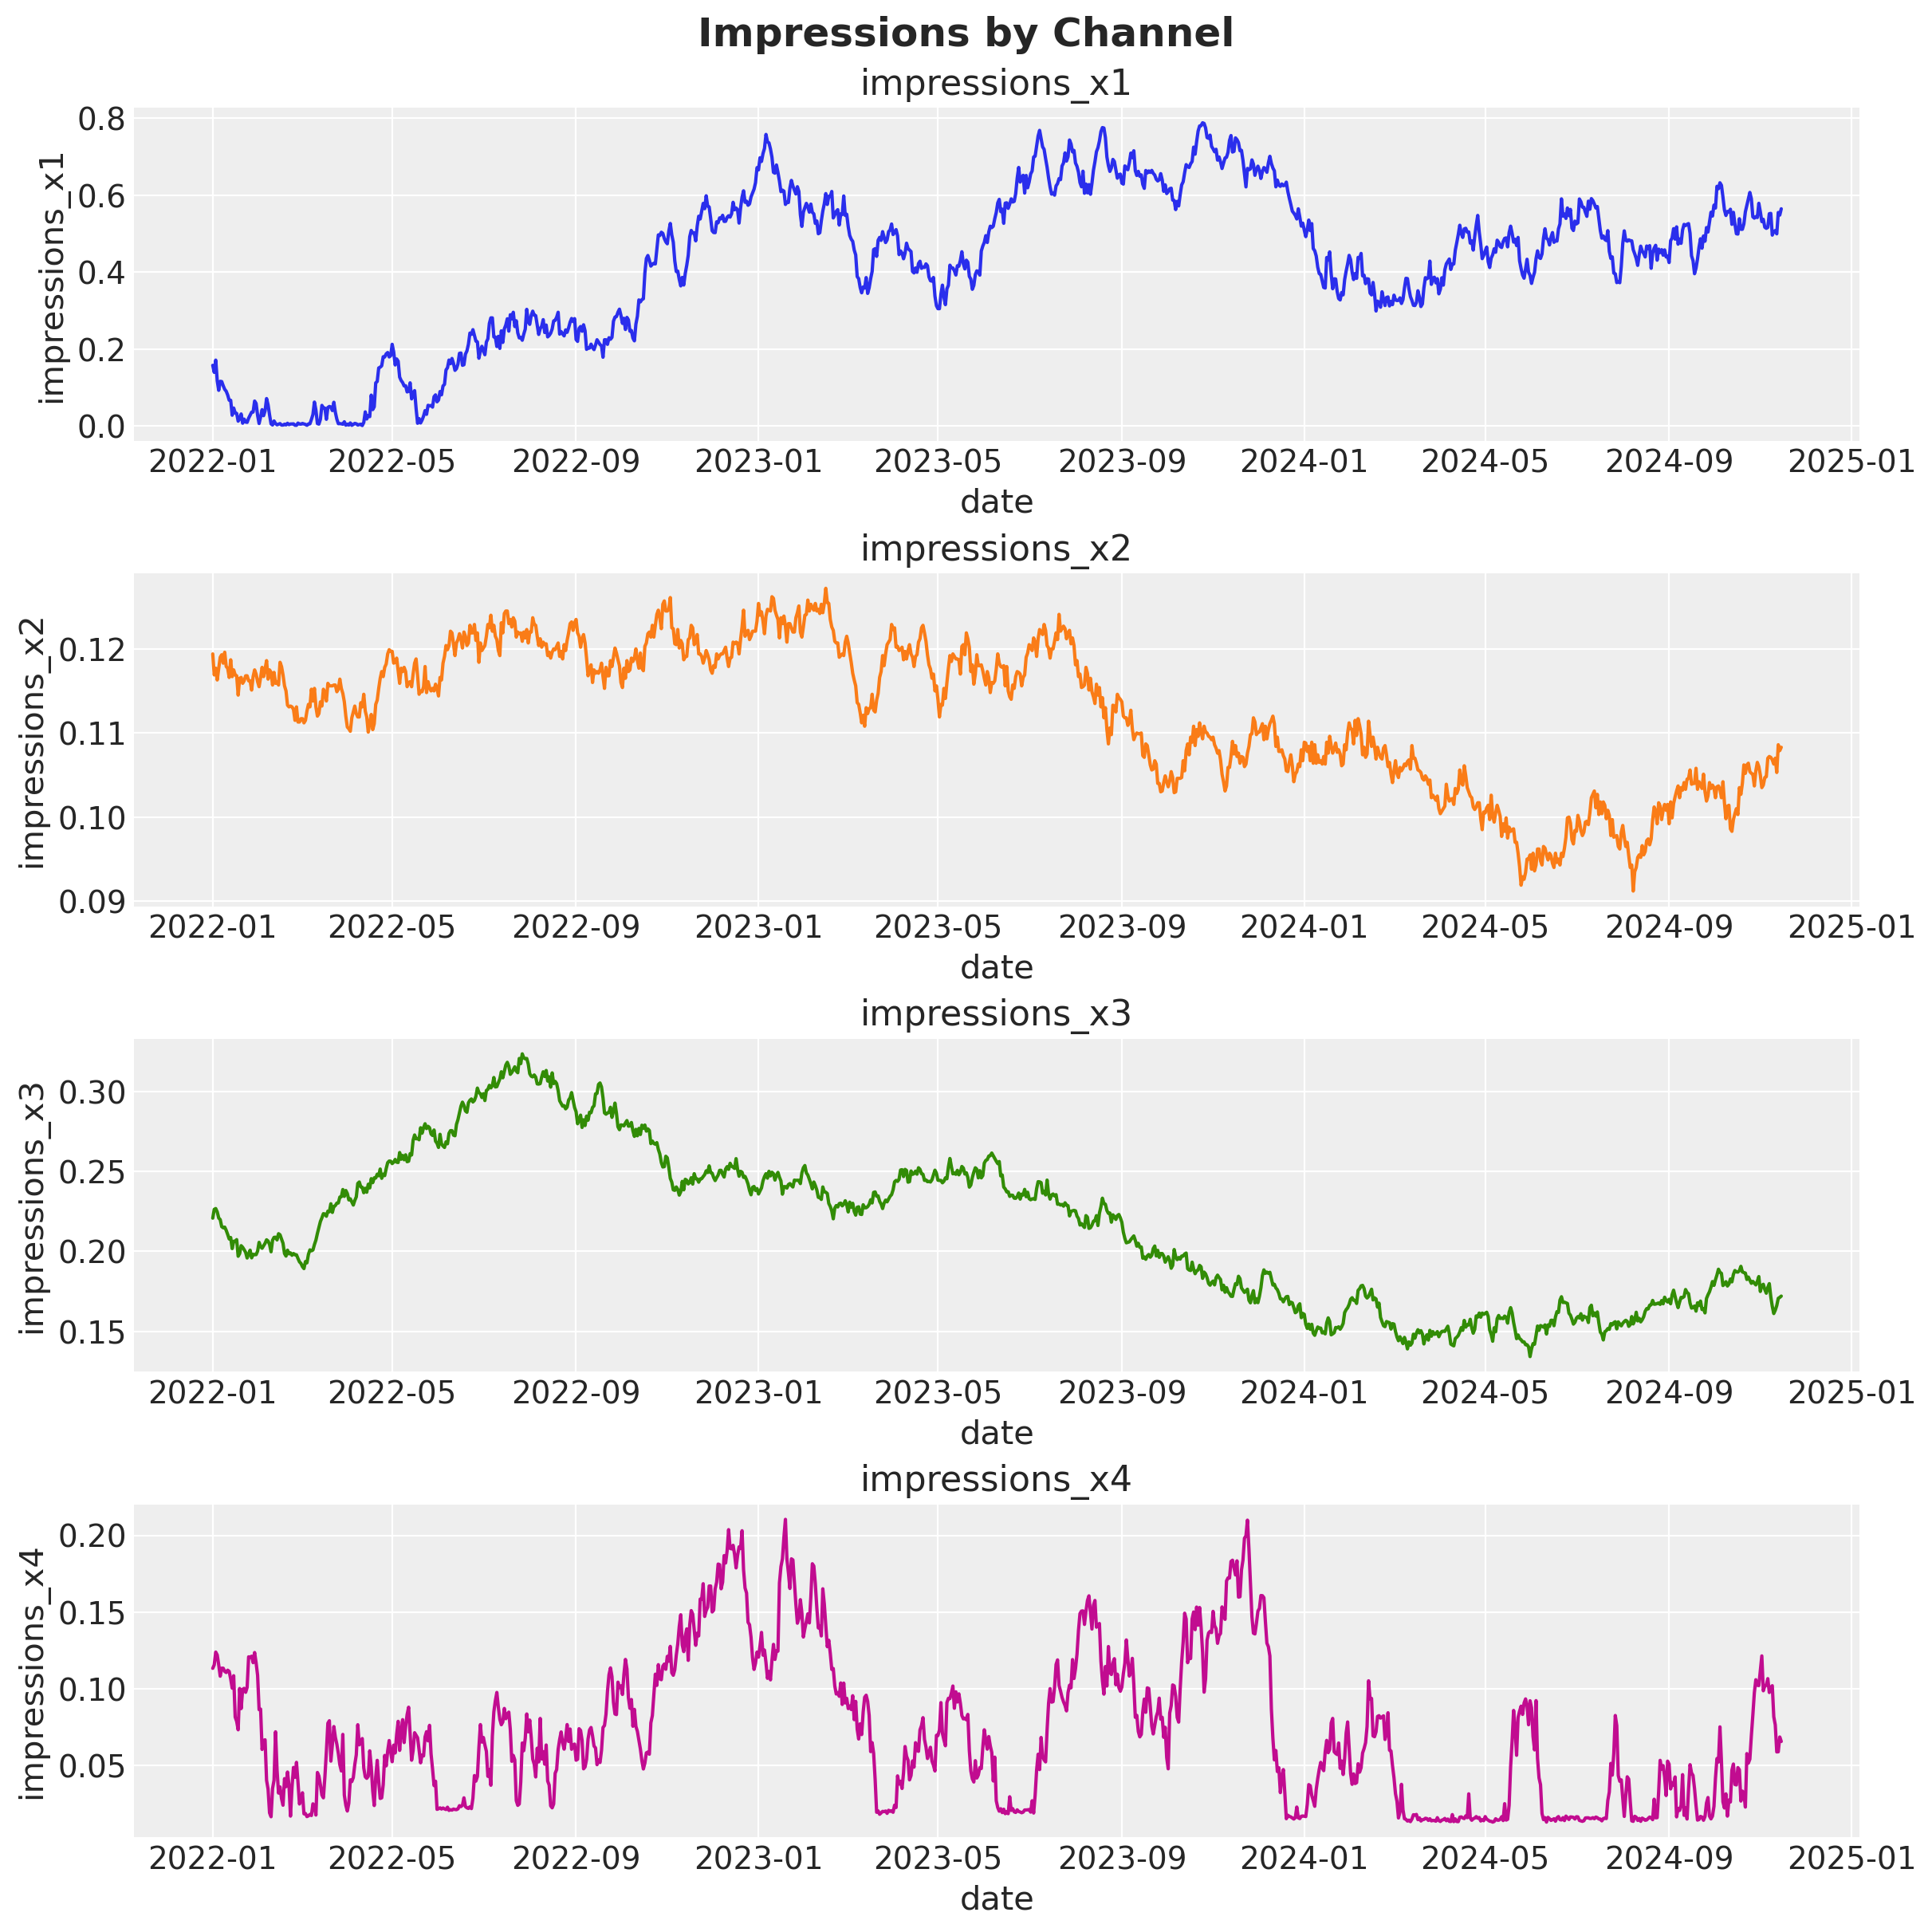

In [4]:
fig, ax = plt.subplots(nrows=4, ncols=1, figsize=(12, 12))

channel_columns = [f"impressions_x{i}" for i in range(1, 5)]

for i, channel in enumerate(channel_columns):
    sns.lineplot(data=data, x="date", y=channel, color=f"C{i}", ax=ax[i])
    ax[i].set(title=channel)

fig.suptitle("Impressions by Channel", fontsize=18, fontweight="bold");

In [5]:
# Split data into train and test sets
train_idx = 879


X_train = data.iloc[:train_idx].drop(columns=["target_var"])
X_test = data.iloc[train_idx:].drop(columns=["target_var"])
y_train = data.iloc[:train_idx]["target_var"]
y_test = data.iloc[train_idx:]["target_var"]

In [6]:
control_columns = [
    "event_2020_09",
    "event_2020_12",
    "event_2021_09",
    "event_2021_12",
    "event_2022_09",
    "trend",
]

In [7]:
adstock_priors = {
    "alpha": Prior("Beta", alpha=1, beta=1, dims="channel"),
}

adstock = GeometricAdstock(l_max=24, priors=adstock_priors)

saturation_priors = {
    "lam": Prior(
        "Gamma",
        mu=2,
        sigma=2,
        dims="channel",
    ),
    "alpha": Prior(
        "Gamma",
        mu=1,
        sigma=1,
        dims="channel",
    ),
}

saturation = MichaelisMentenSaturation(priors=saturation_priors)

In [8]:
# Model config
model_config = {
    "likelihood": Censored(
        Prior(
            "Normal",
            sigma=Prior("HalfNormal", sigma=1),
            dims="date",
        ),
        lower=0,
    )
}

# sampling options for PyMC
sample_kwargs = {
    "tune": 1000,
    "draws": 500,
    "chains": 4,
    "random_seed": SEED,
    "target_accept": 0.84,
    "nuts_sampler": "numpyro",
}

In [ ]:
first_causal_mmm = MMM(
    date_column="date",
    target_column="target_var",
    channel_columns=["impressions_x4"],
    control_columns=control_columns,
    adstock=adstock,
    saturation=saturation,
    model_config=model_config,
    sampler_config=sample_kwargs,
)

first_causal_mmm.build_model(X_train, y_train)

first_causal_mmm.add_original_scale_contribution_variable(
    var=["channel_contribution", "y"]
)

first_causal_mmm.fit(
    X_train,
    y_train,
)

_ = first_causal_mmm.sample_posterior_predictive(
    X_train, extend_idata=True, combined=True
)

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


Output()

Sampling: [y]


Output()

<xarray.Dataset> Size: 28MB
Dimensions:           (date: 879, sample: 2000)
Coordinates:
  * date              (date) datetime64[ns] 7kB 2022-01-01 ... 2024-05-28
  * sample            (sample) object 16kB MultiIndex
  * chain             (sample) int64 16kB 0 0 0 0 0 0 0 0 0 ... 3 3 3 3 3 3 3 3
  * draw              (sample) int64 16kB 0 1 2 3 4 5 ... 495 496 497 498 499
Data variables:
    y                 (date, sample) float64 14MB 0.4397 0.4331 ... 0.9023
    y_original_scale  (date, sample) float64 14MB 0.4491 0.4423 ... 0.9215
Attributes:
    created_at:                 2025-11-06T20:54:53.576333+00:00
    arviz_version:              0.22.0
    inference_library:          pymc
    inference_library_version:  5.26.1

In [11]:
X_train["impressions_x1_diff"] = X_train["impressions_x1"].diff()
X_train["impressions_x4_diff"] = X_train["impressions_x4"].diff()

second_causal_mmm = MMM(
    date_column="date",
    target_column="impressions_x4_diff",
    channel_columns=["impressions_x1_diff"],
    adstock=NoAdstock(
        l_max=1
    ),  # We remove the adstock because we want to estimate the causal effect of x1 on x4 which is purely linear
    saturation=NoSaturation(
        priors={"beta": Prior("Gamma", mu=0.7, sigma=0.4)}
    ),  # linear beta
    sampler_config=sample_kwargs,
)

second_causal_mmm.build_model(
    X_train.drop(columns=["impressions_x4_diff"]),
    X_train["impressions_x4_diff"],
)

second_causal_mmm.add_original_scale_contribution_variable(
    var=["channel_contribution", "y"]
)

second_causal_mmm.fit(
    X_train.drop(columns=["impressions_x4_diff"]),
    X_train["impressions_x4_diff"],
)

second_causal_mmm.sample_posterior_predictive(
    X_train.drop(columns=["impressions_x4_diff"]),
    extend_idata=True,
    combined=True,
)

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

Output()

Sampling: [y]


Output()

<xarray.Dataset> Size: 28MB
Dimensions:           (date: 879, sample: 2000)
Coordinates:
  * date              (date) datetime64[ns] 7kB 2022-01-01 ... 2024-05-28
  * sample            (sample) object 16kB MultiIndex
  * chain             (sample) int64 16kB 0 0 0 0 0 0 0 0 0 ... 3 3 3 3 3 3 3 3
  * draw              (sample) int64 16kB 0 1 2 3 4 5 ... 495 496 497 498 499
Data variables:
    y                 (date, sample) float64 14MB 0.41 0.1744 ... -0.2908 0.1577
    y_original_scale  (date, sample) float64 14MB 0.01821 0.007742 ... 0.007002
Attributes:
    created_at:                 2025-11-06T20:56:39.867427+00:00
    arviz_version:              0.22.0
    inference_library:          pymc
    inference_library_version:  5.26.1

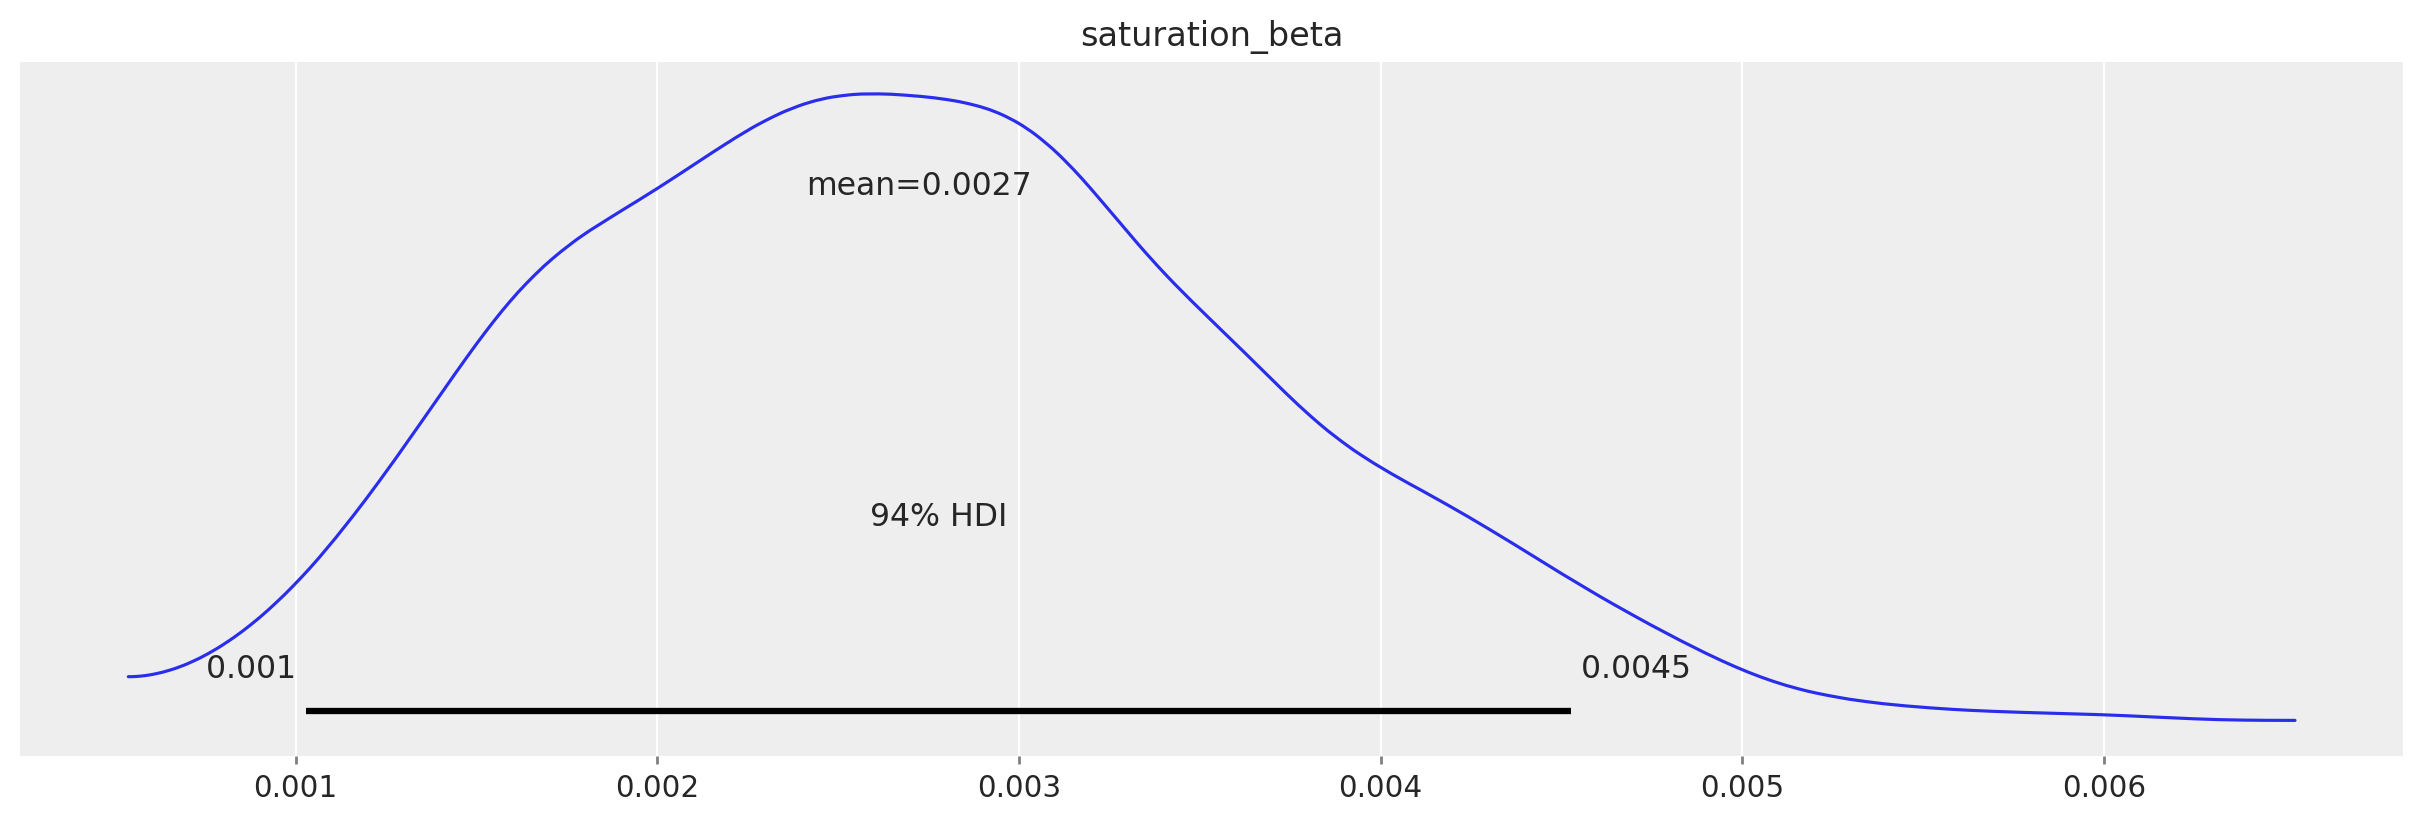

In [ ]:
az.plot_posterior(
    second_causal_mmm.fit_result * second_causal_mmm.scalers._target.item(),
    var_names=[
        "saturation_beta",
    ],
    figsize=(12, 4),
);

In [26]:
# Create xarray with proper broadcasting for chain, draw, date dimensions
impressions_x1_values = X_train["impressions_x1"].to_numpy()  # shape: (date,)
saturation_beta_scaled = (
    second_causal_mmm.idata.posterior.saturation_beta
    * second_causal_mmm.scalers._target.item()
)  # shape: (chain, draw)

# Broadcast to create (chain, draw, date) output
posterior_result = (
    impressions_x1_values[None, None, :] * saturation_beta_scaled.to_numpy()[:, :, None]
)

posterior_contribution_x1_over_x4 = xr.DataArray(
    posterior_result,
    dims=["chain", "draw", "date"],
    coords={
        "chain": second_causal_mmm.idata.posterior.chain,
        "draw": second_causal_mmm.idata.posterior.draw,
        "date": X_train.index,
    },
)

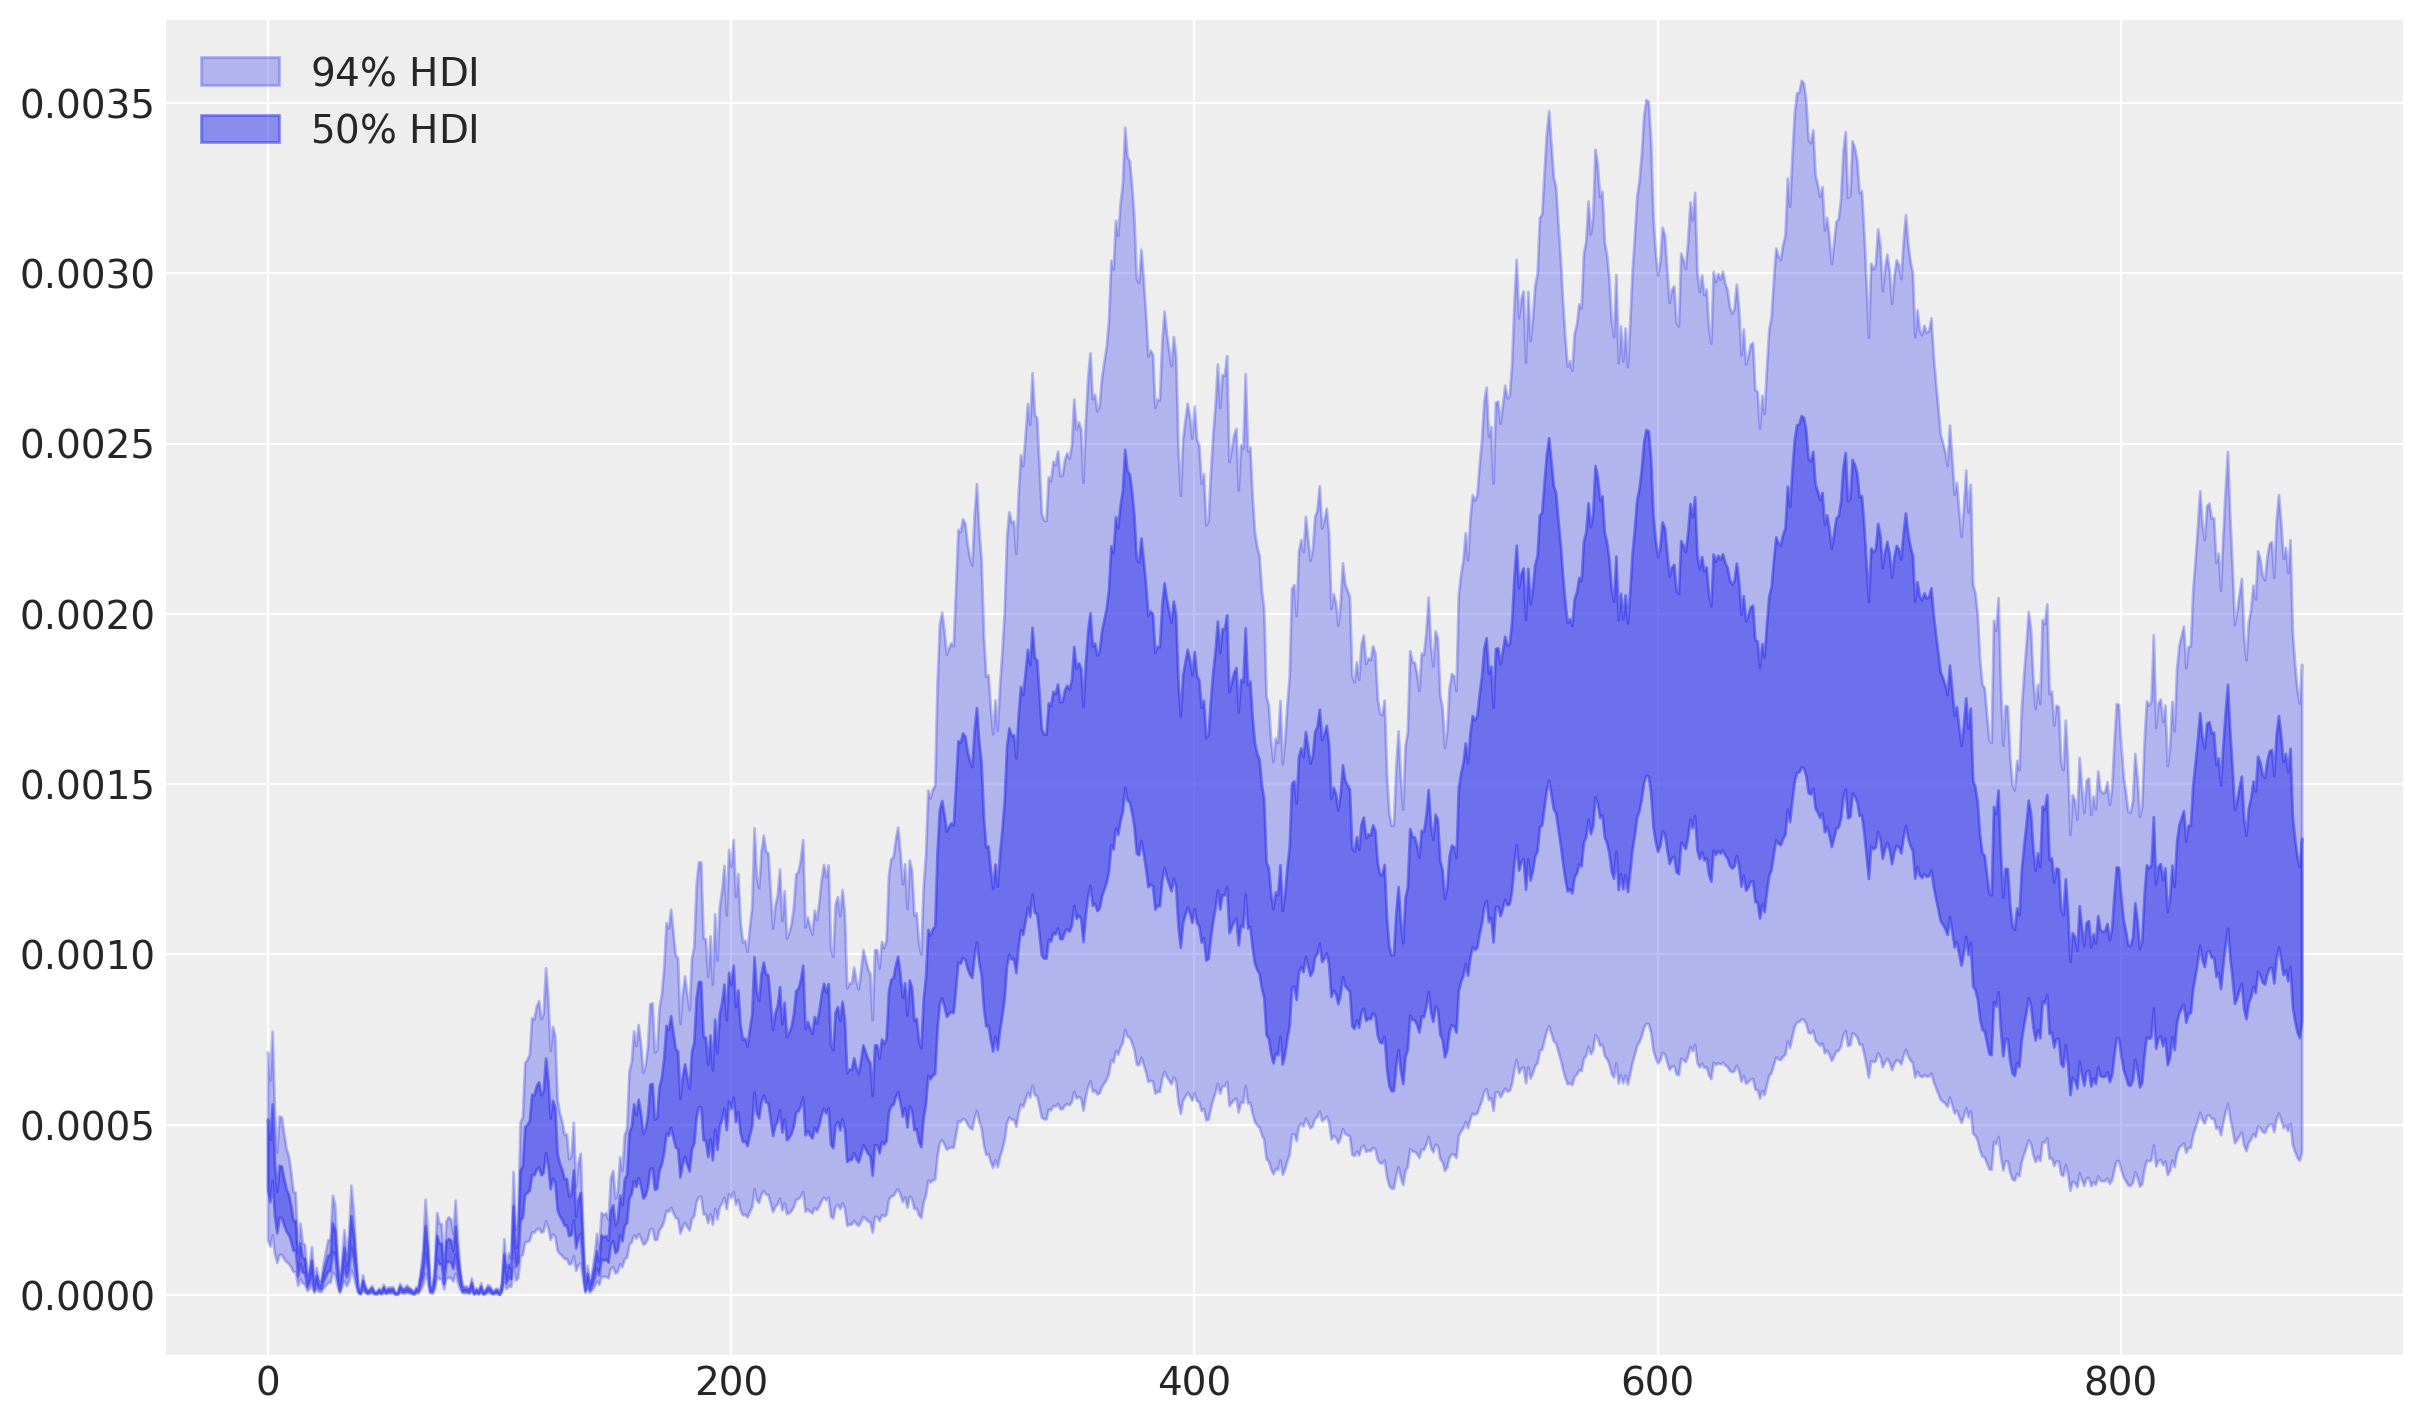

In [39]:
fig, ax = plt.subplots()

az.plot_hdi(
    X_train.index,
    posterior_contribution_x1_over_x4,
    hdi_prob=0.94,
    color="C0",
    fill_kwargs={"alpha": 0.3, "label": r"$94\%$ HDI"},
    smooth=False,
    ax=ax,
)

az.plot_hdi(
    X_train.index,
    posterior_contribution_x1_over_x4,
    hdi_prob=0.5,
    color="C0",
    fill_kwargs={"alpha": 0.5, "label": r"$50\%$ HDI"},
    smooth=False,
    ax=ax,
)

ax.legend(loc="upper left")